# Consistency Models

참고
+ score based model : https://dlaiml.tistory.com/entry/Score-Based-Generative-Modeling-through-Stochastic-Differential-Equations
+ paper review : https://kimjy99.github.io/%EB%85%BC%EB%AC%B8%EB%A6%AC%EB%B7%B0/consistency-model/  
지금 open-ai에 계시는 yang song님의 논문.

## Contributions
+ Diffusion 모델의 sampling 문제 해결을 위해 consistency model 이라는 것을 새롭게 제안. (1-step generation이 가능)
+ pre-trained model로부터 distilling은 물론, 새롭게 training하는데에도 사용할 수 있다.
+ non-GAN
+ training loss의 구성이 상당히 흥미롭다.

## Introduction

Diffusion models(aka score-based generative models)은 여러 이미지생성분야에 사용되고있다.  
compute 와 sample quality간의 trade-off는 여전히 중요한 문제이다.  
기존의 iterative sampling의 이점을 놓지지 않고 single-step generation을 하고싶다.

__consistency models__  
self-consistency : points on the same trajectory map(by PF ODE) to the same initial point(by CM)


<img src="https://drive.google.com/uc?id=1CqQ36HRiYzeivgtGatUTU9KXp1uQEs5Y
" height=160>

해당 consistency model을 __Training__할 때 PF ODE solver가 필요하다.  
이것을 사전학습된 모델(empirical PF Solver)을 사용할 것이냐 : __Distillation__  
근사한 solver 값을 이용할 것이냐 : __Isolation__  
두가지 방법으로 나뉜다.

## Diffusion Models

### Score based model

생성모델의 궁극적인 목표는 데이터 분포 $p_{data}(x)$로부터 실제 데이터를 셈플링하는 것이다.  
따라서, 그러한 분포에 근사시킬 모델 $p_\theta(x)$ 정의하여 학습한다.

이를 특정한 함수 $f_\theta(x)$를 이용하여 다음과 같이 정의할 수 있다.  
$p_\theta(x) = \cfrac{e^{-f_\theta(x)}}{Z_\theta}$

이 때, Z를 통해 적분값이 1이 되도록 하여 probabilistic model이 되도록하고, 이 때의 $f$를 energy-based model이라고 불린다.

하지만 이 때 Z값은 다루기가 힘들기 때문에 이것의 log값의 미분값을 이용하고자 한다. 그렇게 하면, 데이터 x로부터 Z는 상수취급받기 때문에 날려버릴 수 있다.

즉, $s_\theta(x) \approx \nabla_x\log p(x)$하면 된다.(문제정의!)  
$s$ : score function


이를 통해 score함수를 근사하려면 많은 데이터가 필요한다. 그러기 위해서 데이터를 perturbing 하는 방법(노이즈 추가)이 사용된다.  
이 때, 사전에 다양한 크기의 noise를  scheduling 하여 score function을 학습한다.

(이 쯤에서부터 Diffusion model이 보이기 시작한다.)

noise의 scale을 continuous하게 설정하면, Stochastic Differential Equation(SDE)로 표현할 수 있게 된다.

(equation 1)
$$\mathbb{d}x = f(x, t)\mathbb{d}t + g(t)\mathbb{d}w$$  
f(x, t) : drift term  
g(t) : diffusion term  
dw : 아주 작은 noise

위의 SDE를 통해 continuous하게, 그리고 multiple한 단계로 원본 데이터에 대해 noise를 넣어줄 수 있다.  
여기에서 dx를 어떻게 정의하냐에 따라서 DDPM이 되기도, 혹은 다른 SDE 모델이 되기도 한다.

해당 SDE에 대해 reverse SDE가 정의되어있다.  

$$\mathbb{d}x = [f(x, t) - g^2(t)\nabla_x\log p_t(x)]\mathbb{d}t + g(t)\mathbb{d}\bar{w}$$

하지만 위의 식을 살펴보면 마지막 dw 부분으로 인해 reverse process를 거쳤을 때 값들의 변동성이 크므로 likelihood값을 제대로 구할 수 없게 된다.  
따라서, SDE로부터 ODE로 변형이 가능하다.  
(eqation 2)
$$\mathbb{d}x_t = \big[\mu(x_t, t) - \cfrac{1}{2}\sigma(t)^2 \nabla\log p_t(x_t)\big]\mathbb{d}t$$

이를 Probabilistic Flow ODE(PF ODE)라고 말하며,  
sampling quality, latent control 등의 장점을 가져갈 수 있다.

여기에 특별히, $\mu(x, t) = 0, \sigma(t) = \sqrt{2t}$로 설정.   
즉, $p_t(x) = \mathcal{N}(x, t^2I), x \sim p_{data}(x)$와 같이 설정하여 학습한 모델(EDM)에 대해서 다음의 PF ODE를 갖는다.

(eqation 3)
$$\cfrac{\mathbb{d}x_t}{\mathbb{d}t} = -ts_\phi(x_t, t)$$

이를 잘 학습하여 얻어낸 모델을 앞으로 empirical PF ODE solver라고 부를 것이다.

이를 통해 얻어낸 sample을 $\hat{x}$와 같이 표기한다.

## Consistency Models

이제 single step으로 생성할 수 있게 해주는 모델인 consistency model을 정의할 것이다.

### function definition


<img src="https://drive.google.com/uc?id=1tFlKw4FEGFWZFAZ6RmYQF_7HOLzX7p6S" height=220>

PF ODE의 solution trajectory가 존재한다고 가정하자.

우리가 원하는 것은 임의의 time step $t$에 대해서  
$f : (x_t, t) \rightarrow x_\epsilon$  
을 만족하는 함수이다. 즉, 함수 값이 동일한 것이다.

### Parameterization
우선, $f(x_\epsilon, \epsilon) = x_\epsilon$을 boundary condition으로 갖게 한다. 또한, 이 조건으로 인해 모델이 성공적으로 학습하게 된다.  
따라서, 아래와 같은 모델을 생각해볼 수 있다.

(eqation 4)
$$f_\theta(x, t) =  \begin{cases} x & \; t = \epsilon, \\ F_\theta(x, t) & \; t \in (\epsilon, T]. \end{cases}$$

이를 skip connection을 통해 파라미터화 해서  한번에 작성하면,  
(eqation 5)  
$$f_\theta(x, t) = c_{skip}(t)x + c_{out}(t)F_\theta(x, t)$$  
$c_{skip}(\epsilon) = 1, c_{out}(\epsilon) = 0$

### Sampling

<img src="https://drive.google.com/uc?id=1ogjMRfSnD63jtTrTiIIJR88mvSH6sJms" height=250>

1. 원하는 N번에 해당하는 time point들을 설정한다.
2. $\tau_n$에 해당하는 크기의 noise를 넣은 데이터 $\hat{x}_{\tau_n}$을 얻어낸다.
3. 점점 noise크기를 줄여가며 충분히 좋은 sample을 얻을 때까지 반복한다.

위의 알고리즘을 통해 전혀 보지 않은 데이터(zero shot)에 대해서도 iterative하게 생성하기 때문에 좋은 퀄리티를 얻어낼 수 있다.

## Training Consistency Models via __Distillation__

먼저 time steps를 discrete하게 정의 해주면,   
$t_1 = \epsilon < t_2 < ... < t_N = T$에 대하여,

$$t_i = (\epsilon^{1/\rho} + \cfrac{i-1}{N-1}(T^{1/\rho} - \epsilon^{1/\rho}))^\rho$$  
와 같이 스캐쥴링할 수 있다.  
time steps라고 정의하지만, 결국 n번 째 시간대에 어느정도의 노이즈를 넣을건지 variance크기를 결정한 것이라고 생각할 수 있다.

In [ ]:
import matplotlib.pyplot as plt

def plot_time_steps(rho):
    epsilon = 1e-8
    T = 0.1
    N = 100
    ro = 7

    time_steps = [(epsilon**(1/rho) + (i-1)/(N-1) * (T**(1/rho) - epsilon**(1/rho)))**rho for i in range(1, N+1)]

    plt.plot(time_steps)
    plt.title(f"rho : {rho}")

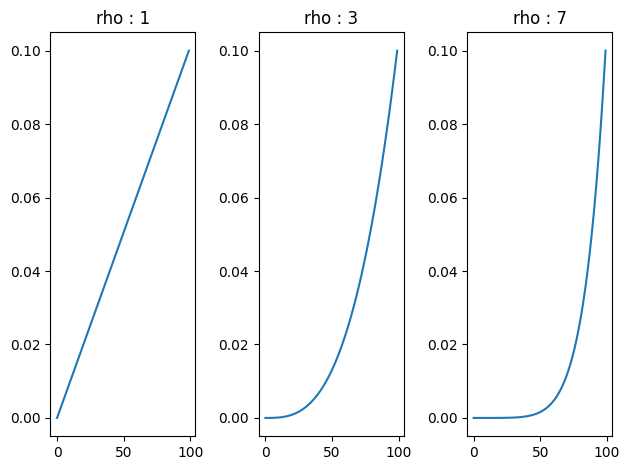

In [ ]:
plt.subplot(1, 3, 1)
plot_time_steps(1)
plt.subplot(1, 3, 2)
plot_time_steps(3)
plt.subplot(1, 3, 3)
plot_time_steps(7)
plt.tight_layout()
plt.show()

그리고, 사전에 갖고있는 ODE solver(=pre-trained model)를 이용하면 다음과 같이 reverse process를 정의할 수 있다.  
(eqation 6)  
$$\hat{x}^\phi_{t_n} := x_{t_{n+1}} + (t_n - t_{n+1})\Phi(x_{t_{n+1}}, t_{n+1};\phi)$$

이를 score function 으로 바꿔주면 다음과 같다.  
$$\hat{x}^\phi_{t_n} := x_{t_{n+1}} - (t_n - t_{n+1})t_{n+1}s_\phi(x_{t_{n+1}}, t_{n+1})$$

즉, 우리는 $x_{t+1}$과 $\hat{x}_{t_n}^\phi$데이터 pair를 얻게 된다.

(eqation 7)  
$$L^N_{CD}(\theta, \theta^-; \phi) := \mathbb{E}[\lambda(t_n)d(f_\theta(x_{t_{n+1}}, t_{n+1}), f_{\theta^-}(\hat{x}^\phi_{t_n}, t_n))]$$

+ $\theta$ : consistency model parameters (online network)
+ $\theta^-$ : target network parameters

<img src="https://drive.google.com/uc?id=1o_WhZvi_JsWnZ4An-gWahYjbQjMA1IdK" height=300>

1. x, n을 각각 dataset, $\mathcal{U}[[1, N-1]]$ 으로부터 셈플링.
2. $x_{t_{n+1}}$을 PF ODE를 통해 sampling해준다.
3. 사전학습한 ODE solver를 통해 $\hat{x}^\phi_{t_n}$을 얻는다.
4. loss 값을 계산한다.
5. constency model의 파라미터를 update한다.
6. target model의 파라미터를 moving average에 따라 update한다.(기울기 흐르지 않게함)

마지막 6번의 방식을 EMA라고 하는데, 가중치에 이를 적용하는 방식이 기존에 여러개 있다.

Deep-Q learning, mean teacher method(consistency training), momentum based contrastive learning(MoCo)

+ DQN방식은 target network를 고정한다는 면에서 비슷

+ mean teacher method는 adverserial attack에 대해 network가 일관된 feature를 뽑아낼 수 있도록 학습하는 regularization 방법이다.

<img src="https://drive.google.com/uc?id=1BVn3Nz6RN3Oe8zYFcm20A1SyfH7wWota" height=300>

+ MoCo는 query로 target net의 결과값, key들로 online net의 결과값을 사용한다고 볼 수 있다.

<img src="https://drive.google.com/uc?id=1_7AI4PYmanOn-WRfH1YGBuayBfYyHVgP" height=250>

그래서, 다시 돌아와서  
$f_\theta(x_{t_{n+1}}, t_{n+1}), f_{\theta^-}(\hat{x}^\phi_{t_n}, t_n)$가 비슷해지도록 학습했을 때 왜 $f_\theta$가 $x_\epsilon$를 출력하도록 하는 것인지 궁금할 수 있다.

$f(x_{t_{n+1}}, t_{n+1}) \approx f(\hat{x}^\phi_{t_n}, t_n) \approx f(x_{t_n}, t_n) ... \approx f(x_{t_1}, t_1) = x_{t_1} = x_\epsilon$

와 같은 과정으로 정당화될 수 있다.  
이에 대한 이론적인 증명은 논문에 thm,appendix에 잘 나와있다.

## Training Consistency Models in __Isolation__

$N \rightarrow \infty$의 경우, ode solver를 사용해야 하는데, 이전처럼 consistency distillation하는 경우처럼 empirical PF ODE solver를 사용할 수 없으므로 다른 방법을 사용해야한다.  
이 때, $x \sim p_{data}$, $x_t \sim \mathcal{N}(x;t^2\mathbf{I})$가 주어졌을 때,   
$\nabla \log{p_t(x_t)} = - \mathbb{E}\bigg[ \cfrac{x_t - x}{t^2} \bigg| x_t \bigg]$를 사용한다.  


일반적으로 CT를 학습하는 경우에는 ($N < \infty$) 다음의 loss를 사용한다.

(equation 10)
$$\mathbf{E}[\lambda(t_n) d(f_{\theta}(x + t_{n+1}z, t_{n+1}), f_{\theta^-}(x + t_n z, t_n))]$$

이전에 CD에서 학습할 때에는 $x_{t_{n+1}}$으로부터 $x^\phi_{t_n}$을 얻어내고 각각을 모델에 학습시켰는데, 이번에는 $x_{t_{n+1}}$와 $x_{t_n}$을 각각 얻어내고 모델에 넣어 학습한다.

<img src="https://drive.google.com/uc?id=1IPkyh4rIMW7ZDWCFbqet-jzzy8_RzDBm" height=300>

이전의 CD와 차이점이라면, 여기선 training마다 step schedule $N$과 EMA rate $\mu$가 변화한다는 것이다.

loss의 variance와 bias측면을 생각해보았을 때,  
$N$ 값이 작으면 ($\nabla t$가 크면) 수렴이 빨라진다.(low variance, high bias  
반대로 $N$ 값이 커지면($\nabla t$가 작으면) generality가 좋다.(high variance, low bias)

따라서, 학습 초반에는 N을 작게, 뒤로갈수록 N 값을 크게 하는것이 performance 측면에서 용이하다.  
또한, 이에 맞춰서 $\mu$값은 점점 감소하도록 변화시켜준다. ($\mu$값이 작으면 현재 training하는 online network로부터 더 많이 파라미터를 가져오게됨.)

$$N(k) = \bigg\lceil \sqrt{\cfrac{k}{K}((s_1 + 1)^2 - s^2_0) + s^2_0} - 1 \bigg\rceil + 1$$  
$$\mu(k) = \exp \bigg( \cfrac{s_0\log{\mu_0}}{N(k)} \bigg)$$

## Experiments

### Training

크게 다음의 부분에 주목하였다.
+ metric function $d(\cdot, \cdot)$
+ ODE solver
+ number of discretization steps $N$ (CD)
+ schedule function $N(\cdot), \mu(\cdot)$ (CT)


<img src="https://drive.google.com/uc?id=1_4aQYjb0NWUWmkcmdfa0INg0z1tHq1su" height=200>

+ metric에대해 $\ell_2$, $\ell_1$, LPIPS 중에선, LPIPS가 가장 좋은 성능을 보였다.
+ ODE solver는 Heun이 좋았으며
+ N = 18에서 가장 성능이 좋았다.(여기서도 N이 늘어난다고 반드시 좋은 것이 아닌게 DDGAN에서의 GAN모델 크기 이슈와 같이 consistency 모델의 capacity문제가 아닐까 생각.)
+ CT에서도 LPIPS를 사용하였고, ODE solver는 필요 없다.(그냥 $t_{n}, t_{n+1}$번째를 사용)

<img src="https://drive.google.com/uc?id=1KLe_QSrppKwHdD-ayCbd7sQEyl-VOAdF" height=300>

### Distillation performance

기존의 방법인 progressive distillation(PD)와 비교하였다.

<img src="https://drive.google.com/uc?id=1UCJsc7Ke46cqctXy1002kZPcLP_dSGY5" >

전체적으로 더 좋은 성능을 보였다.

<img src="https://drive.google.com/uc?id=1RODOalJl9AEIDcd2SIQCV_OFrhsBLIzp" width=400>